In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/data-aeroflow/data_step 2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/data')

In [4]:
import os
from typing import Union
import numpy as np
import cv2
import openfoamparser_mai as Ofpp
import random

PathLike = Union[str, os.PathLike]

LOW_DIM = 'low_dim'
HIGH_DIM = 'high_dim'


def max_timestep(simulation: PathLike) -> PathLike:
    timestep = str(max(map(lambda x: int(x) if x.isdigit() else -1, os.listdir(simulation))))
    return os.path.join(simulation, timestep)


def read_mesh_centers(simulation: PathLike):
    timestep = max_timestep(simulation)
    Cx = Ofpp.parse_internal_field(os.path.join(timestep, 'Cx'))
    Cy = Ofpp.parse_internal_field(os.path.join(timestep, 'Cy'))
    Cz = Ofpp.parse_internal_field(os.path.join(timestep, 'Cz'))
    return np.dstack((Cx, Cy, Cz))[0]


def read_speed_vector_field(simulation: PathLike):
    timestep = max_timestep(simulation)
    U = Ofpp.parse_internal_field(os.path.join(timestep, 'U'))
    return U


def read_pressure_field(simulation: PathLike):
    timestep = max_timestep(simulation)
    p = Ofpp.parse_internal_field(os.path.join(timestep, 'p'))
    return p


def read_simulation(simulation: PathLike):
    C = read_mesh_centers(simulation)
    U = read_speed_vector_field(simulation)
    p = read_pressure_field(simulation)
    return C, U, p


def read_geometry(path_to_geometry: PathLike):
    low_dim_path = os.path.join(path_to_geometry, LOW_DIM)
    high_dim_path = os.path.join(path_to_geometry, HIGH_DIM)
    low_list_dir = [i for i in os.listdir(low_dim_path) if i[0] != '.']
    high_list_dir = [i for i in os.listdir(high_dim_path) if i[0] != '.']
   
    low_dim = np.array(list(map(read_simulation, map(lambda x: os.path.join(path_to_geometry,LOW_DIM, x), low_list_dir))))
    high_dim = np.array(list(map(read_simulation, map(lambda x: os.path.join(path_to_geometry,HIGH_DIM, x), high_list_dir))))

    return low_dim, high_dim


def transform_to_tensor(C, U, p):
    
    coords = pd.DataFrame(C, columns =['x', 'y'])
    maps_x = {}
    maps_y = {}

    for ind, val in enumerate(sorted(coords['x'].unique())):
        maps_x[val] = ind

    for ind, val in enumerate(sorted(coords['y'].unique())):
        maps_y[val] = ind
      
    coords['x'] = coords['x'].map(maps_x).astype(int)
    coords['y'] = coords['y'].map(maps_y).astype(int)
    
    U = pd.DataFrame(U, columns=['U_x', 'U_y'])
    p = pd.DataFrame(p, columns=['p'])
    
    result = np.zeros((int(coords['x'].max())+1, 
                       int(coords['y'].max())+1,
                       3
                     ))

    data = coords.join(U).join(p)
    for i in range(len(data)):
        point = data.iloc[i]
        x, y = point['x'], point['y']
        result[int(x)][int(y)][0] = point['U_x']
        result[int(x)][int(y)][1] = point['U_y']
        result[int(x)][int(y)][2] = point['p']
    return result, data

# Python function to manipulate OpenFOAM files
# Developer: Jian-Xun Wang (jwang33@nd.edu)

###############################################################################

# system import
import numpy as np
import numpy.matlib
import sys # Add extra path/directory
import os
import os.path as ospt
import shutil
import subprocess # Call the command line
from subprocess import call
import matplotlib.pyplot as plt # For plotting
import re
import tempfile
import pdb
from matplotlib import pyplot as plt
# local import
from PIL import Image
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPRegressor
import multiprocessing
from functools import partial
import time
import multiprocessing
from functools import partial

import scipy.sparse as sp

global unitTest 
unitTest = False;






def readVectorFromFile(UFile):
	""" 
	Arg: 
	tauFile: The directory path of OpenFOAM vector file (e.g., velocity)

	Regurn: 
	vector: Matrix of vector    
	"""
	resMid = extractVector(UFile)
	fout = open('Utemp', 'w');
	glob_pattern = resMid.group()
	glob_pattern = re.sub(r'\(', '', glob_pattern)
	glob_pattern = re.sub(r'\)', '', glob_pattern)
	fout.write(glob_pattern)
	fout.close();
	vector = np.loadtxt('Utemp')
	return vector





	
def readScalarFromFile(fileName):    
	""" 

	Arg: 
	fileName: The file name of OpenFOAM scalar field

	Regurn: 
	a vector of scalar field    
	"""
	resMid = extractScalar(fileName)
	
	# write it in Tautemp 
	fout = open('temp.txt', 'w')
	glob_patternx = resMid.group()
	glob_patternx = re.sub(r'\(', '', glob_patternx)
	glob_patternx = re.sub(r'\)', '', glob_patternx)
	fout.write(glob_patternx)
	fout.close();
	scalarVec = np.loadtxt('temp.txt')
	return scalarVec


################################################ Regular Expression ##################################################### 


def extractVector(vectorFile):
	""" Function is using regular expression select Vector value out
	
	Args:
	UFile: The directory path of file: U

	Returns:
	resMid: the U as (Ux1,Uy1,Uz1);(Ux2,Uy2,Uz2);........
	"""

	fin = open(vectorFile, 'r')  # need consider directory
	line = fin.read() # line is U file to read
	fin.close()
	### select U as (X X X)pattern (Using regular expression)
	patternMid = re.compile(r"""
	(
	\(                                                   # match(
	[\+\-]?[\d]+([\.][\d]*)?([Ee][+-]?[\d]+)?            # match figures
	(\ )                                                 # match space
	[\+\-]?[\d]+([\.][\d]*)?([Ee][+-]?[\d]+)?            # match figures
	(\ )                                                 # match space
	[\+\-]?[\d]+([\.][\d]*)?([Ee][+-]?[\d]+)?            # match figures
	\)                                                   # match )
	\n                                                   # match next line
	)+                                                   # search greedly
	""",re.DOTALL | re.VERBOSE)
	resMid = patternMid.search(line)
	return resMid    
	
def extractScalar(scalarFile):
	""" subFunction of readTurbStressFromFile
		Using regular expression to select scalar value out 
	
	Args:
	scalarFile: The directory path of file of scalar

	Returns:
	resMid: scalar selected;
			you need use resMid.group() to see the content.
	"""
	fin = open(scalarFile, 'r')  # need consider directory
	line = fin.read() # line is k file to read
	fin.close()
	### select k as ()pattern (Using regular expression)
	patternMid = re.compile(r"""
		\(                                                   # match"("
		\n                                                   # match next line
		(
		[\+\-]?[\d]+([\.][\d]*)?([Ee][+-]?[\d]+)?            # match figures
		\n                                                   # match next line
		)+                                                   # search greedly
		\)                                                   # match")"
	""",re.DOTALL | re.VERBOSE)
	resMid = patternMid.search(line)

	return resMid


### Пример

In [5]:
def convertOFMeshToImage_StructuredMesh(nx,ny,MeshFile,FileName,ext,mriLevel=0,plotFlag=True,ReshapeOrder = 'F'):
	title=['x','y']
	OFVector=None
	OFScalar=None
	for i in range(len(FileName)):
		if FileName[i][-1]=='U':
			OFVector=readVectorFromFile(FileName[i])
			title.append('u')
			title.append('v')
		elif FileName[i][-1]=='p':
			OFScalar=readScalarFromFile(FileName[i])
			title.append('p')
		elif FileName[i][-1]=='T':
			OFScalar=readScalarFromFile(FileName[i])
			title.append('T')
		else:
			print('Variable name is not clear')
			exit()
	nVar=len(title)
	OFMesh=readVectorFromFile(MeshFile)
	Ng=OFMesh.shape[0]
	OFCase=np.zeros([Ng,nVar])
	OFCase[:,0:2]=np.copy(OFMesh[:,0:2])
	if OFVector is not None and OFScalar is not None:
		if mriLevel>1e-16:
			OFVector=foamFileAddNoise.addMRINoise(OFVector,mriLevel)
		OFCase[:,2:4]=np.copy(OFVector[:,0:2])
		OFCase[:,4]=np.copy(OFScalar)
	elif OFScalar is not None:
		OFCase[:,2]=np.copy(OFScalar)
	OFPic=np.reshape(OFCase, (ny,nx,nVar), order=ReshapeOrder)
	if plotFlag:
		pass	#plt.show()
	return OFPic #torch.from_numpy(OFPic)

In [9]:
def read_tensor_low(path):
    ### подгрузка изображения низкого разрешения
    path = max_timestep(path)
    feats = convertOFMeshToImage_StructuredMesh(40, 16, 
                                                f'{path}/C',
                                                [f'{path}/U',
                                                 f'{path}/p'],
                                                [0,1,0,1],0.0,False)
    feats = cv2.resize(feats, (252, 64), interpolation=cv2.INTER_LANCZOS4)
    feats = torch.Tensor(feats)
    return feats 

def read_tensor_high(path):
    path = max_timestep(path)
    answer = convertOFMeshToImage_StructuredMesh(nx=252, ny=64, MeshFile=f'{path}/C',
                                                 FileName=[f'{path}/U',
                                                           f'{path}/p'],
                                                 ext=None)
    answer = torch.Tensor(answer)
    return answer

In [10]:
path_to_geometry='/content/sample_data/data/data_step'

low_dim_files = [os.path.join(path_to_geometry,LOW_DIM, x) 
                 for x in os.listdir(f'{path_to_geometry}/low_dim')
                 if x != '.DS_Store']
high_dim_files = [os.path.join(path_to_geometry,HIGH_DIM, x) 
                  for x in os.listdir(f'{path_to_geometry}/high_dim')
                  if x != '.DS_Store']

data = list(zip(low_dim_files, high_dim_files))
random.shuffle(data)

In [11]:
train = data[:int(len(data) * 0.8)]
val = data[int(len(data) * 0.8):]

In [13]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class USCNNSep(nn.Module):
    def __init__(self,nVarIn=1,nVarOut=1,initWay=None,k=5,s=1,p=2):
        super().__init__()
        self.conv1=nn.Conv2d(1,16,kernel_size=k, stride=s, padding=p)
        self.conv2=nn.Conv2d(16,32,kernel_size=k, stride=s, padding=p)
        self.conv3=nn.Conv2d(32,16,kernel_size=k, stride=s, padding=p)
        self.conv4=nn.Conv2d(16,1,kernel_size=k, stride=s, padding=p)
        self.pixel_shuffle1 = nn.PixelShuffle(1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1=self.relu(self.conv1(x))
        x1=self.relu(self.conv2(x1))
        x1=self.relu(self.conv3(x1))
        x1=self.pixel_shuffle1(self.conv4(x1))

        return x1



In [21]:
def fit_epoch(model, train, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for obj in train:
        inputs = read_tensor_low(obj[0])
        labels = read_tensor_high(obj[1])
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        inputs = inputs.reshape(1, 5, 252, 64)
        labels = labels.reshape(1, 5, 252, 64)
        
        inputs = inputs[:, 2, :, :]
        labels = labels[:, 2, :, :]
        #speed it up
        for param in model.parameters():
            param.grad = None

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        processed_data += 1
              
    train_loss = running_loss / processed_data
    return train_loss


def eval_epoch(model, val, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for obj in val:
        inputs = read_tensor_low(obj[0])
        labels = read_tensor_high(obj[1])

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        inputs = inputs.reshape(1, 5, 252, 64)
        labels = labels.reshape(1, 5, 252, 64) 
        
        inputs = inputs[:, 2, :, :]
        labels = labels[:, 2, :, :]
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(DEVICE)
            loss = criterion(outputs, labels)

        running_loss += loss.item()
        processed_size += 1
    val_loss = running_loss / processed_size
    return val_loss
     

In [22]:
DEVICE = 'cuda'
model = USCNNSep().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
from torchmetrics import MeanAbsolutePercentageError

for i in range(100):
    mse = fit_epoch(model, train, criterion, optimizer)
    print(eval_epoch(model, val, MeanAbsolutePercentageError().to(DEVICE)), eval_epoch(model, val, criterion))

2196.2670699357986 1.376990722119808
3256.528156268597 1.322463008761406
3886.4656366229055 1.2934417948126793
4120.142578589916 1.2733428955078125
4206.805465137959 1.2600382402539254
4318.9479154706005 1.2491019695997239
4594.496606659889 1.2412059970200062
4885.575561201573 1.2352445796132088
5007.408232486248 1.2292677253484725
4957.149259614945 1.2225022427737713
4844.44299801588 1.2150859646499157
4654.148590683937 1.2073675557971
4453.373417198658 1.2000439569354058
4376.589608716965 1.1944269031286239
4309.932466244698 1.189780742675066
4206.290470969677 1.1851564772427081
4158.912952971458 1.1811242632567882
3991.8274238467216 1.1772329941391946
3863.978393745422 1.173831395059824
3764.237532222271 1.1708152778446674
3782.877344918251 1.167785831540823
3628.798903691769 1.164703156799078
3591.931243956089 1.162183004617691
3568.0233828783034 1.1597219660878182
3479.784633708 1.1571860179305076
3490.9019024014474 1.1550751507282258
3405.6675691843034 1.1525575503706933
3307.407

# Ненужный код

In [ ]:
def get_base_pred(i):
    low_dim = data[i][0]
    
    C = read_simulation(low_dim)[0]
    U = read_simulation(low_dim)[1]
    p = read_simulation(low_dim)[2]
    U = U[:, :2]
    C = C[:, :2]
    p = p
    plt.scatter(x=C[:,0], y=C[:,1], c=U[:,0])
    features, df = transform_to_tensor(C,U,p)
    
    pred = cv2.resize(features, (80, 240), interpolation=cv2.INTER_CUBIC)
    pred = torch.Tensor(pred)
    features = torch.Tensor(features)
    
    high_dim = data[i][1]
    
    C = read_simulation(high_dim)[0]
    U = read_simulation(high_dim)[1]
    p = read_simulation(high_dim)[2]
    U = U[:, :2]
    C = C[:, :2]
    p = p
    
    answer, df = transform_to_tensor(C,U,p)
    answer = torch.Tensor(answer)
    
    return pred, answer, features

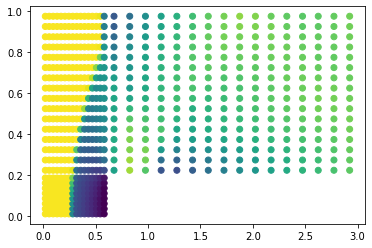

In [ ]:
pred, ans, feats = get_base_pred(10)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from torchmet

In [ ]:
mean_absolute_percentage_error(ans[:,:,1], pred[:,:,1])

33866142000000.0

In [ ]:
mean_absolute_percentage_error(ans[:,:,0], pred[:,:,0])

171827920000000.0

In [ ]:
mean_absolute_percentage_error(ans[:,:,2], pred[:,:,2])

2091626300000000.0

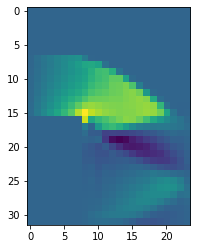

In [ ]:
plt.imshow(feats[:,:,1])

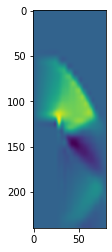

In [ ]:
plt.imshow(pred[:,:,1])

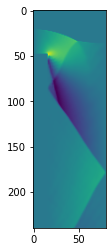

In [ ]:
plt.imshow(ans[:,:,1])

In [ ]:
MeanAbsolutePercentageError()(pred, ans)

tensor(145334.2031)

In [ ]:
base_T = torch.Tensor(base)
answer_T = torch.Tensor(answer)
answer2_T = torch.Tensor(answer2)


In [ ]:
MeanAbsolutePercentageError()(base_T, answer_T)

tensor(55306.9805)

In [ ]:
MeanAbsolutePercentageError()(answer2_T, answer_T)

tensor(9.0253)

In [ ]:
base = cv2.resize(features, (80, 240), interpolation=cv2.INTER_CUBIC)

In [ ]:
for f in low_dim_files:
    C = read_simulation(f)[0]
    U = read_simulation(f)[1]
    p = read_simulation(f)[2]
    U = U[:, :2]
    C = C[:, :2]
    p = p
    features, data = transform_to_tensor(C,U,p)
    print(features.shape)

(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32, 24, 3)
(32,

In [ ]:
for f in high_dim_files:
    C = read_simulation(f)[0]
    U = read_simulation(f)[1]
    p = read_simulation(f)[2]
    U = U[:, :2]
    C = C[:, :2]
    p = p
    features, data = transform_to_tensor(C,U,p)
    print(features.shape)

(240, 80, 3)
(240, 80, 3)
(240, 80, 3)
(240, 80, 3)
(240, 80, 3)
(240, 80, 3)
(240, 80, 3)
(240, 80, 3)
(240, 80, 3)
(240, 80, 3)


KeyboardInterrupt: 

In [ ]:
C = read_simulation(low_dim_files[0])[0]
U = read_simulation(low_dim_files[0])[1]
p = read_simulation(low_dim_files[0])[2]
U = U[:, :2]
C = C[:, :2]
p = p
features, data = transform_to_tensor(C,U,p)

In [ ]:
C = read_simulation(high_dim_files[0])[0]
U = read_simulation(high_dim_files[0])[1]
p = read_simulation(high_dim_files[0])[2]
U = U[:, :2]
C = C[:, :2]
p = p
answer, data = transform_to_tensor(C,U,p)

In [ ]:
features.shape

(32, 24, 3)

In [ ]:
answer.shape

(240, 80, 3)

Text(0.5, 1.0, 'Velocity Vector Field (U)')

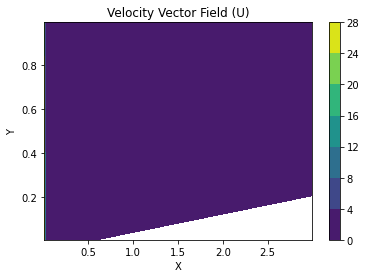

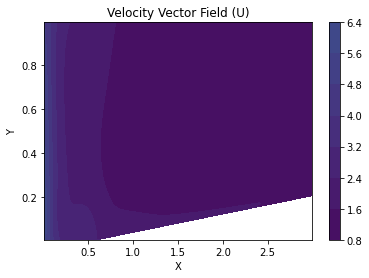

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pykrige import UniversalKriging
import numpy as np

path_to_data = './data_with_C/data_step 2/high_dim'
simulation_name = 'vel1.1616161616161615'


simulation = os.path.join(path_to_data, simulation_name)

C_high, U_high, p_high = read_simulation(simulation)

vmin = np.nanmin(p_high)
vmax = np.nanmax(p_high)

fig, ax = plt.subplots()

contour = plt.tricontourf(C_high[:, 0], C_high[:, 1], p_high, vmin=vmin, vmax=vmax)
fig.colorbar(contour, ax=ax, orientation='vertical')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Velocity Vector Field (U)")


path_to_data = './data_with_C/data_step 2/low_dim'
simulation_name = 'vel1.1616161616161615'

simulation = os.path.join(path_to_data, simulation_name)

C_low, U_low, p_low = read_simulation(simulation)

krieg = UniversalKriging(C_low[:, 0], C_low[:, 1], p_low, variogram_model='spherical')

z, _ = krieg.execute(style='points', xpoints=C_high[:, 0], ypoints=C_high[:, 1])

fig, ax = plt.subplots()
contour = plt.tricontourf(C_low[:, 0], C_low[:, 1], z, vmin=vmin, vmax=vmax)
fig.colorbar(contour, ax=ax, orientation='vertical')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Velocity Vector Field (U)")


